# Instacart Market Basket Analysis

# Introduction

For reference, the information is sourced from https://www.kaggle.com/c/instacart-market-basket-analysis/overview and the data dictionary is sourced from https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b

“The Instacart Online Grocery Shopping Dataset 2017”, Accessed from https://www.instacart.com/datasets/grocery-shopping-2017 on <date>

Goal: To predict the product/s in an order

The five important steps involved in Data Science is as shown below:

1. Getting the data.
2. Cleaning the data
3. Exploring the data
4. Building the data
5. Presenting the data

# Initialization

In [1]:
import polars as pl
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
color = sns.color_palette()

In [2]:
df_aisles = pl.read_csv('../data/raw/aisles.csv', low_memory = False)
df_aisles.head()

aisle_id,aisle
i64,str
1,"""prepared soups salads"""
2,"""specialty cheeses"""
3,"""energy granola bars"""
4,"""instant foods"""
5,"""marinades meat preparation"""


In [3]:
df_departments = pl.read_csv('../data/raw/departments.csv', low_memory = False)
df_departments.head()

department_id,department
i64,str
1,"""frozen"""
2,"""other"""
3,"""bakery"""
4,"""produce"""
5,"""alcohol"""


In [4]:
df_products = pl.read_csv('../data/raw/products.csv', low_memory = False)
df_products.head()

product_id,product_name,aisle_id,department_id
i64,str,i64,i64
1,"""Chocolate Sandwich Cookies""",61,19
2,"""All-Seasons Salt""",104,13
3,"""Robust Golden Unsweetened Oolong Tea""",94,7
4,"""Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce""",38,1
5,"""Green Chile Anytime Sauce""",5,13


At first glance, the products table can be denormalized and joined with the aisles and departments tables.

In [5]:
df_orders = pl.read_csv('../data/raw/orders.csv', low_memory = False)
df_orders.head()

order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
i64,i64,str,i64,i64,i64,f64
2539329,1,"""prior""",1,2,8,null
2398795,1,"""prior""",2,3,7,15.0
473747,1,"""prior""",3,3,12,21.0
2254736,1,"""prior""",4,4,7,29.0
431534,1,"""prior""",5,4,15,28.0


This table indicates the user ID and order number which will help associate users to an order and understand the product mix for prior and subsequent orders. More importantly, the order set is specified which categorizes orders into prior orders, training orders, and testing orders. Time series analysis can also be performed with the date of week, hour of day, and days since prior order.

# Exploration

In [6]:
df_orders.shape

(3421083, 7)

In [7]:
df_orders.describe

<bound method DataFrame.describe of shape: (3421083, 7)
┌──────────┬─────────┬──────────┬──────────────┬───────────┬─────┬──────┐
│ order_id ┆ user_id ┆ eval_set ┆ order_number ┆ order_dow ┆ ord ┆ days │
│ ---      ┆ ---     ┆ ---      ┆ ---          ┆ ---       ┆ er_ ┆ _sin │
│ i64      ┆ i64     ┆ str      ┆ i64          ┆ i64       ┆ hou ┆ ce_p │
│          ┆         ┆          ┆              ┆           ┆ r_o ┆ rior │
│          ┆         ┆          ┆              ┆           ┆ f_d ┆ _ord │
│          ┆         ┆          ┆              ┆           ┆ ay  ┆ er   │
│          ┆         ┆          ┆              ┆           ┆ --- ┆ ---  │
│          ┆         ┆          ┆              ┆           ┆ i64 ┆ f64  │
╞══════════╪═════════╪══════════╪══════════════╪═══════════╪═════╪══════╡
│ 2539329  ┆ 1       ┆ prior    ┆ 1            ┆ 2         ┆ 8   ┆ null │
├╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌╌╌╌╌╌╌┼╌╌╌╌╌┼╌╌╌╌╌╌┤
│ 2398795  ┆ 1       ┆ prior    ┆ 2            ┆ 3      

There are over 3 million rows in the orders table, and describe shows most reorders occur 1.5 to 7 days after their prior order.

In [8]:
df_orders['eval_set'].unique()

shape: (3,)
Series: 'eval_set' [str]
[
	"prior"
	"test"
	"train"
]

The orders data has been conveniently labeled with prior, test, and train to help our analysis.

## Order Count

In [9]:
df_order_count = (
    df_orders
    .groupby('user_id')
    .agg(
        [
            pl.col('user_id').count()
        ]
    )
    .sort('user_id_count', reverse=True)
)

df_order_count.head()

user_id,user_id_count
i64,u32
196912,100
31552,100
7120,100
116368,100
181936,100


In [10]:
df_order_count.shape

(206209, 2)

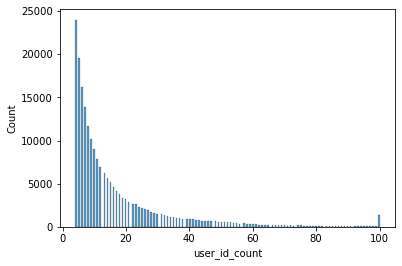

In [11]:
fig = sns.histplot(x=df_order_count['user_id_count'])

The histogram of the order number shows that the orders are not uniformly distributed as expected with a heavy right skew, and an interesting spike at what appears to be at 100 orders.  Let's determine the size of 80% of our orders.

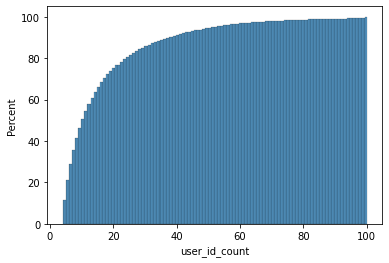

In [12]:
fig = sns.histplot(x=df_order_count['user_id_count'], stat='percent', cumulative=True)

At a quick glance, the orders table shows that roughly 80% of users have ordered from 4 to 25 times and it may be prudent to limit our data to this subset to efficiently model our predictions.  Note that orders with less than 4 items were not included in the original dataset.

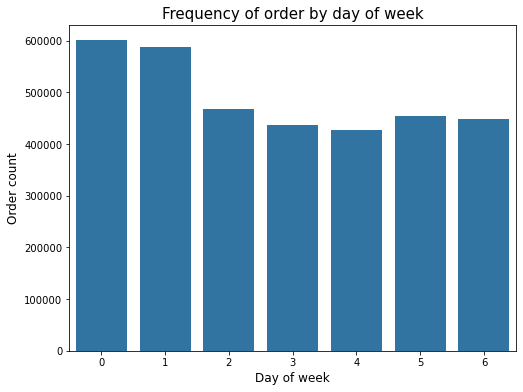

In [13]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_orders.to_pandas(), x='order_dow', color=color[0])

plt.ylabel('Order count', fontsize=12)
plt.xlabel('Day of week', fontsize=12)

plt.title('Frequency of order by day of week', fontsize=15)

plt.show()

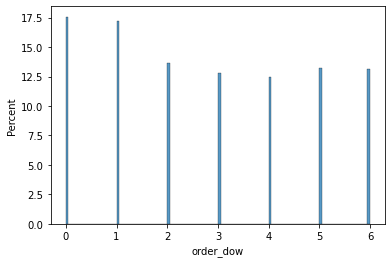

In [14]:
fig = sns.histplot(x=df_orders['order_dow'], stat='percent')

The data dictionary does not explicity state which days these numbers correspond to so it will be presumed that 0 and 1 correspond to Saturday and Sunday.  It is plausible that users may have orders on the weekend to prepare for the week ahead.

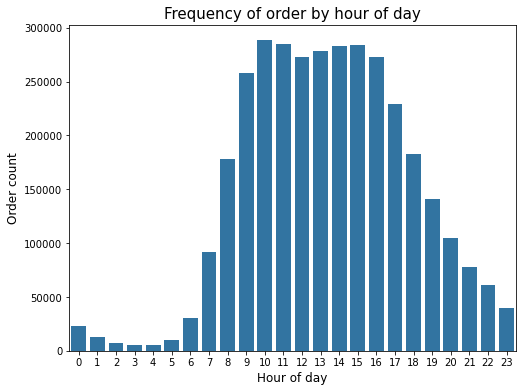

In [15]:
plt.figure(figsize=(8,6))
sns.countplot(data=df_orders.to_pandas(), x='order_hour_of_day', color=color[0])

plt.ylabel('Order count', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)

plt.title('Frequency of order by hour of day', fontsize=15)

plt.show()

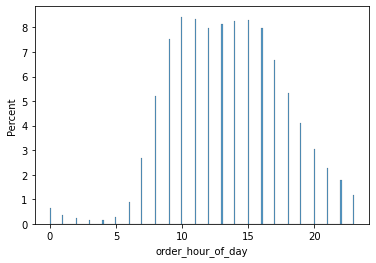

In [16]:
fig = sns.histplot(x=df_orders['order_hour_of_day'], stat='percent')

As expected, most orders occur during daytime hours.

In [17]:
df_orders_group_by_dow_hod = (
    df_orders
    .groupby(['order_dow', 'order_hour_of_day'])
    .agg(
        [
            (pl.col("order_number").count().alias("order_count_by_dow_hod"))
        ]
        )
)

df_orders_group_by_dow_hod.head()


order_dow,order_hour_of_day,order_count_by_dow_hod
i64,i64,u32
1,1,1830
4,9,31409
4,14,33625
4,11,33857
5,6,4866


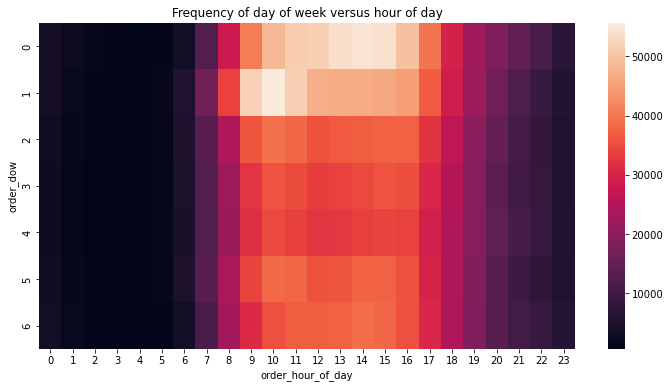

In [18]:
df_orders_pivot = df_orders_group_by_dow_hod.to_pandas().pivot(index='order_dow', columns='order_hour_of_day', values='order_count_by_dow_hod')

plt.figure(figsize=(12,6))
sns.heatmap(df_orders_pivot)
plt.title('Frequency of day of week versus hour of day')

plt.show()

It would appear that Sunday mornings from 9-11am and Saturday afternoons from 1-3pm are the most popular times of day for orders.

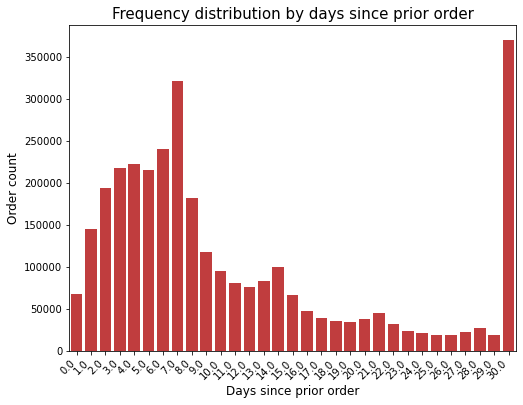

In [19]:
plt.figure(figsize=(8,6))
ax = sns.countplot(data=df_orders.to_pandas(), x='days_since_prior_order', color=color[3])

plt.ylabel('Order count', fontsize=12)
plt.xlabel('Days since prior order', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Frequency distribution by days since prior order', fontsize=15)

plt.show()

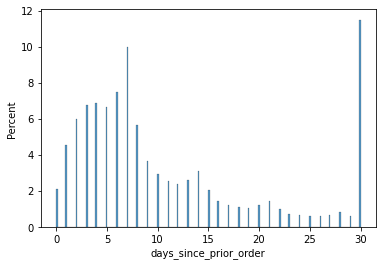

In [20]:
fig = sns.histplot(x=df_orders['days_since_prior_order'], stat='percent')

Both 30 and 7 days stand out as the most common number of days since a user's prior order.

# Data Preparation

In [21]:
df_train_order_products = pl.read_csv('../data/raw/order_products__train.csv', low_memory = False)
df_train_order_products.head()

order_id,product_id,add_to_cart_order,reordered
i64,i64,i64,i64
1,49302,1,1
1,11109,2,1
1,10246,3,0
1,49683,4,0
1,43633,5,1


In the training data set, the products in the orders are shown.  The cart order sequence and the reordered flag will undoubtedly be insightful.

In [22]:
df_order_products_prior = pl.read_csv('../data/raw/order_products__prior.csv', low_memory = False)
df_order_products_prior.head()

order_id,product_id,add_to_cart_order,reordered
i64,i64,i64,i64
2,33120,1,1
2,28985,2,1
2,9327,3,0
2,45918,4,1
2,30035,5,0


There is another dataset for the prior orders for products.  Let's check if these records are distinct or included within the training set. 

In [23]:
df_order_products_combined = pl.concat([df_train_order_products, df_order_products_prior])

df_order_products_combined.shape

(33819106, 4)

In [24]:
df_order_products_combined.drop_duplicates().shape

(33819106, 4)

With this we have validated that the records are distinct from each other and can use this to understand the whole picture after joining with our remaining datasets.

In [25]:
df_products_aisles = df_products.join(df_aisles, on='aisle_id', how='left')
df_products_aisles_departments = df_products_aisles.join(df_departments, on='department_id', how='left')

df_products_aisles_departments.head()

product_id,product_name,aisle_id,department_id,aisle,department
i64,str,i64,i64,str,str
1,"""Chocolate Sandwich Cookies""",61,19,"""cookies cakes""","""snacks"""
2,"""All-Seasons Salt""",104,13,"""spices seasonings""","""pantry"""
3,"""Robust Golden Unsweetened Oolong Tea""",94,7,"""tea""","""beverages"""
4,"""Smart Ones Classic Favorites Mini Rigatoni With Vodka Cream Sauce""",38,1,"""frozen meals""","""frozen"""
5,"""Green Chile Anytime Sauce""",5,13,"""marinades meat preparation""","""pantry"""


In [26]:
df_order_products_combined = df_order_products_combined.join(df_products_aisles_departments, on='product_id', how='left')

df_order_products_combined.head()

order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
i64,i64,i64,i64,str,i64,i64,str,str
1,49302,1,1,"""Bulgarian Yogurt""",120,16,"""yogurt""","""dairy eggs"""
1,11109,2,1,"""Organic 4% Milk Fat Whole Milk Cottage Cheese""",108,16,"""other creams cheeses""","""dairy eggs"""
1,10246,3,0,"""Organic Celery Hearts""",83,4,"""fresh vegetables""","""produce"""
1,49683,4,0,"""Cucumber Kirby""",83,4,"""fresh vegetables""","""produce"""
1,43633,5,1,"""Lightly Smoked Sardines in Olive Oil""",95,15,"""canned meat seafood""","""canned goods"""


Notice that the orders are not linked with the user.

In [27]:
df_train_order_products_combined = df_order_products_combined.join(df_orders, on='order_id', how='left')

df_train_order_products_combined.head()

order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
i64,i64,i64,i64,str,i64,i64,str,str,i64,str,i64,i64,i64,f64
1,49302,1,1,"""Bulgarian Yogurt""",120,16,"""yogurt""","""dairy eggs""",112108,"""train""",4,4,10,9.0
1,11109,2,1,"""Organic 4% Milk Fat Whole Milk Cottage Cheese""",108,16,"""other creams cheeses""","""dairy eggs""",112108,"""train""",4,4,10,9.0
1,10246,3,0,"""Organic Celery Hearts""",83,4,"""fresh vegetables""","""produce""",112108,"""train""",4,4,10,9.0
1,49683,4,0,"""Cucumber Kirby""",83,4,"""fresh vegetables""","""produce""",112108,"""train""",4,4,10,9.0
1,43633,5,1,"""Lightly Smoked Sardines in Olive Oil""",95,15,"""canned meat seafood""","""canned goods""",112108,"""train""",4,4,10,9.0


This table brings over 32 million orders and mirrors the structure of the training set.  The left join is used to filter out the testing data for orders.



In [28]:
df_train_order_products_combined['eval_set'].unique()

shape: (2,)
Series: 'eval_set' [str]
[
	"train"
	"prior"
]

The data frame only contains the prior and train data, and we can now output this as a CSV for model building.

In [29]:
# df_train_order_products_combined.to_pickle('../data/processed/data_order_products.pkl')

In [30]:
product_count = df_train_order_products_combined['product_name'].value_counts().head(10)
product_count.columns = ['product_name', 'frequency_count']

product_count

product_name,frequency_count
str,u32
"""Banana""",491291
"""Bag of Organic Bananas""",394930
"""Organic Strawberries""",275577
"""Organic Baby Spinach""",251705
"""Organic Hass Avocado""",220877
"""Organic Avocado""",184224
"""Large Lemon""",160792
"""Strawberries""",149445
"""Limes""",146660


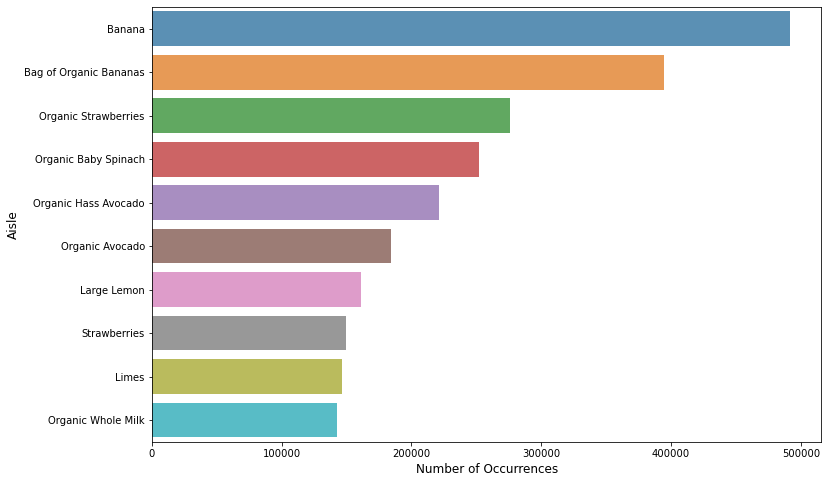

In [31]:
plt.figure(figsize=(12,8))
sns.barplot(data=product_count.to_pandas(), x='frequency_count', y='product_name', alpha=0.8)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Aisle', fontsize=12)

plt.show()

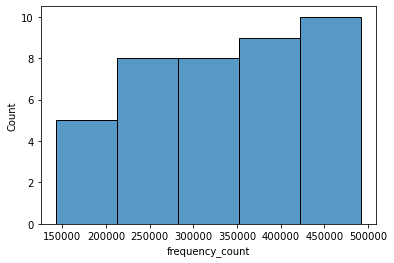

In [32]:
fig = sns.histplot(x=product_count['frequency_count'], cumulative=True)

Organic fruits and vegetables immediately stand out, so let's dive into the aisle.

In [33]:
order_products_aisle = df_train_order_products_combined['aisle'].value_counts().head(10)
order_products_aisle.columns = ['aisle_name', 'frequency_count']

order_products_aisle

aisle_name,frequency_count
str,u32
"""fresh fruits""",3792661
"""fresh vegetables""",3568630
"""packaged vegetables fruits""",1843806
"""yogurt""",1507583
"""packaged cheese""",1021462
"""milk""",923659
"""water seltzer sparkling water""",878150
"""chips pretzels""",753739
"""soy lactosefree""",664493


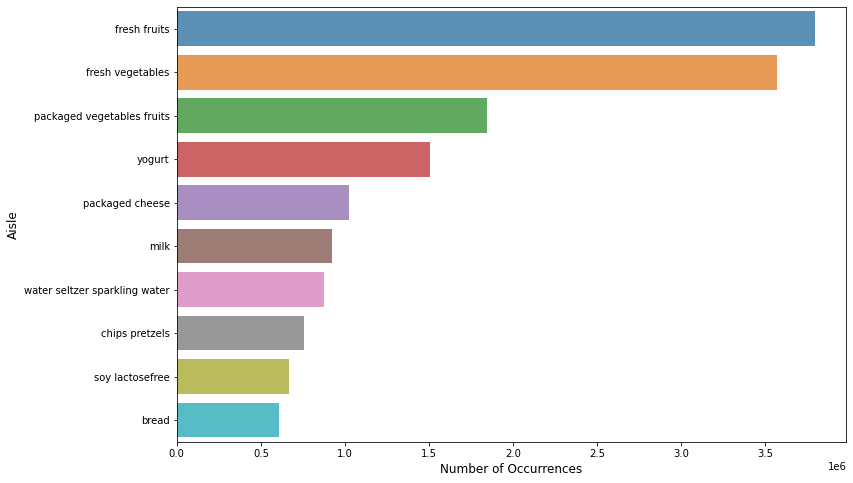

In [34]:
plt.figure(figsize=(12,8))
sns.barplot(data=order_products_aisle.to_pandas(), y='aisle_name', x='frequency_count', alpha=0.8)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Aisle', fontsize=12)

plt.show()

Let's dig into the departments.

In [35]:
order_products_department = df_train_order_products_combined['department'].value_counts().head(10)
order_products_department.columns = ['department_name', 'frequency_count']

order_products_department

department_name,frequency_count
str,u32
"""produce""",9888378
"""dairy eggs""",5631067
"""snacks""",3006412
"""beverages""",2804175
"""frozen""",2336858
"""pantry""",1956819
"""bakery""",1225181
"""canned goods""",1114857
"""deli""",1095540


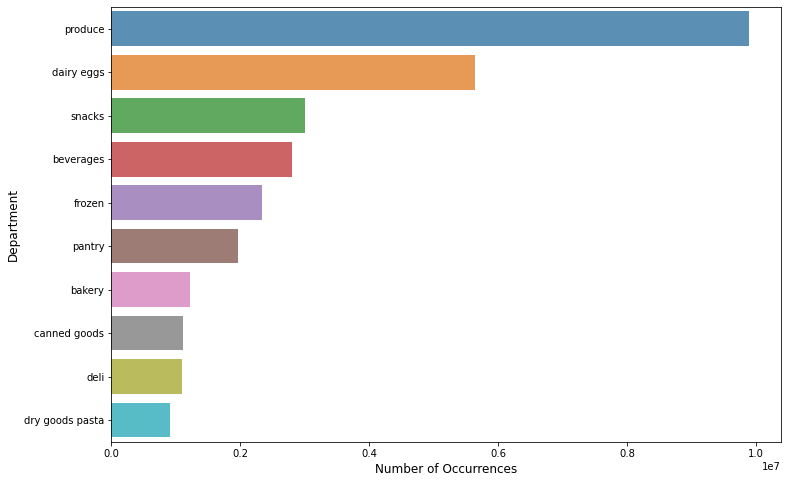

In [38]:
plt.figure(figsize=(12,8))
sns.barplot(data=order_products_department.to_pandas(), y='department_name', x='frequency_count', alpha=0.8)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.ylabel('Department', fontsize=12)

plt.show()

Let's understand how large the orders are

In [205]:
df_product_count = (
    df_order_products_combined
    .groupby('order_id')
    .agg(
        [
            pl.col('order_id').count()
        ]
    )
    .sort('order_id_count', reverse=True)
)

df_product_count.head()

order_id,order_id_count
i64,u32
1564244,145
790903,137
61355,127
2970392,121
2069920,116


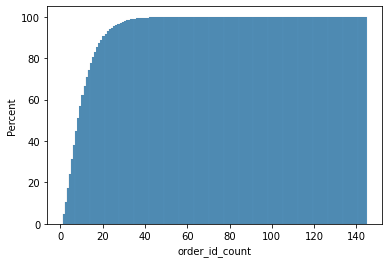

In [206]:
fig = sns.histplot(x=df_product_count['order_id_count'], stat='percent', cumulative=True)

For the actual orders, we can spot that roughly 20 items are in the cart for 80% of the orders. 

In [126]:
df_train_order_products_combined['reordered'].sum() / df_train_order_products_combined.shape[0]

0.5900617242809434

In the entire data set, 59% of the products in the orders were classified as reordered.

In [203]:
df_order_reordered_count = (
    df_train_order_products_combined
    .groupby('order_id')
    .agg(
        [
            pl.col('reordered').sum()
        ]
    )
    .sort('reordered_sum', reverse=True)
)

df_order_reordered_count.head()

order_id,reordered_sum
i64,i64
790903,130
3308010,114
2069920,107
1384519,102
1657096,101


Note that reordered is binary coded with 0 as not reordered and 1 as reordered, so sum is used instead of count when aggregating.  Also we can see which orders are associated with a reorder and how often.

In [193]:
df_product_reordered_count = (
    df_train_order_products_combined
    .groupby('product_id')
    .agg(
        [
            pl.col('reordered').sum()
        ]
    )
    .sort('reordered_sum', reverse=True)
)

df_product_reordered_count.head()

product_id,reordered_sum
i64,i64
24852,415166
13176,329275
21137,214448
21903,194939
47209,176173


In [189]:
df_product_reordered_count.tail()

product_id,reordered_sum
i64,i64
25873,0
34785,0
13953,0
16833,0
32305,0


Conversely we can note which products are reordered and how often.

What about items that were never reordered?

In [215]:
df_product_reordered_percentage = (
    df_train_order_products_combined
    .groupby('reordered')
    .agg(
        [
            (pl.col('reordered') >= 1).sum().alias('Total Products Reordered')
            , (pl.col('reordered') < 1).sum().alias('Total Products Without Reorder')
            , (pl.col('reordered').sum().alias('Total Products'))
        ]
    )
)

df_product_reordered_percentage.head()

reordered,Total Products Reordered,Total Products Without Reorder,Total Products
i64,u32,u32,i64
0,0,13863746,0
1,19955360,0,19955360


Notice that using sum does not produce the correct results and a count should be used instead. 

In [211]:
df_product_reordered_percentage = (
    df_train_order_products_combined
    .groupby('reordered')
    .agg(
        [
            (pl.col('reordered') == 1).count().alias('Total Products Reordered')
            , (pl.col('reordered') == 0).count().alias('Total Products Without Reorder')
            , (pl.col('reordered').count().alias('Total Products'))
        ]
    )
)

df_product_reordered_percentage.head()

reordered,Total Products Reordered,Total Products Without Reorder,Total Products
i64,u32,u32,u32
0,13863746,13863746,13863746
1,19955360,19955360,19955360


In [214]:
df_product_reordered_percentage = (
    df_train_order_products_combined
    .groupby('reordered')
    .agg(
        [
            (pl.col('reordered').count().alias('Total Products'))
        ]
    )
)

df_product_reordered_percentage.head()

reordered,Total Products
i64,u32
0,13863746
1,19955360


The count is identical regardless of the filter, but technically it too produces the incorrect results for each group.

There may be further patterns if we investigate reordered products at a higher level, such as the aisle or the department.

In [46]:
df_department_reordered_percentage = (
    df_train_order_products_combined
    .groupby(
        ['department'
        , 'reordered'
        ]
        )
    .agg(
        [
            (pl.col('reordered').count())
        ]
    )
    .sort('department')
)

df_department_reordered_percentage.head()

department,reordered,reordered_count
str,i64,u32
"""alcohol""",1,90992
"""alcohol""",0,68302
"""babies""",0,185290
"""babies""",1,253453
"""bakery""",1,769880


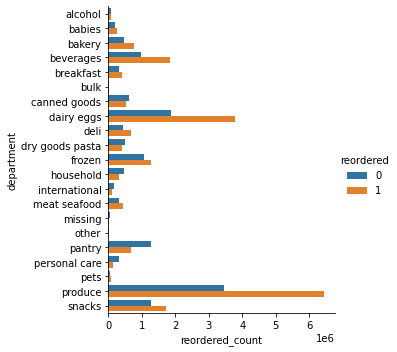

In [67]:
fig = sns.catplot(
    data=df_department_reordered_percentage.to_pandas()
    , x='reordered_count'
    , y='department'
    , hue='reordered'
    , kind='bar'
    )

## Order Analysis

Let's examine the order distribution for users.

In [127]:
user_id_count =  (
    df_orders
    .groupby('user_id')
    .agg(
        [
            pl.col('user_id').count()
        ]
    )
    .sort('user_id_count', reverse=True)
)

user_id_count.head()

user_id,user_id_count
i64,u32
189408,100
142304,100
31552,100
68880,100
38016,100


There are over 200,000 users in this dataset.

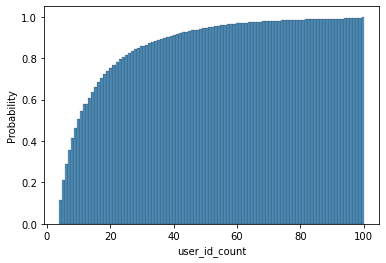

In [128]:
fig = sns.histplot(x=user_id_count['user_id_count'], stat='percent', cumulative=True)

For efficiency, it is reasonable to look only at users with 20 orders maximum as it comprises almost 80% of the data.

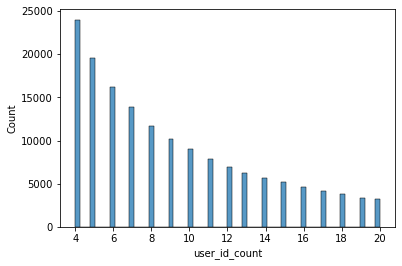

In [129]:
fig = sns.histplot(x=user_id_count['user_id_count'], binrange=[4, 20])

In [130]:
order_id_count =  (
    df_train_order_products
    .groupby('order_id')
    .agg(
        [
            pl.col('order_id').count()
        ]
    )
    .sort('order_id_count', reverse=True)
)

order_id_count.head()

order_id,order_id_count
i64,u32
2813632,80
1395075,80
949182,77
341238,76
2869702,76


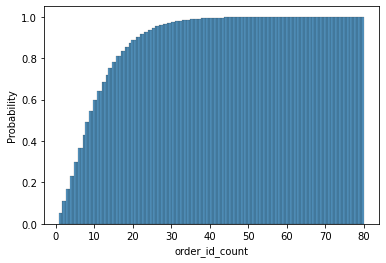

In [131]:
fig = sns.histplot(x=order_id_count['order_id_count'], stat='percent', cumulative=True)

For efficiency, it is reasonable to look at orders with 20 products maximum as it comprises almost 90% of the data.

In [132]:
order_id_prior_count =  (
    df_order_products_prior
    .groupby('order_id')
    .agg(
        [
            pl.col('order_id').count()
        ]
    )
    .sort('order_id_count', reverse=True)
)

order_id_prior_count.head()

order_id,order_id_count
i64,u32
1564244,145
790903,137
61355,127
2970392,121
2069920,116


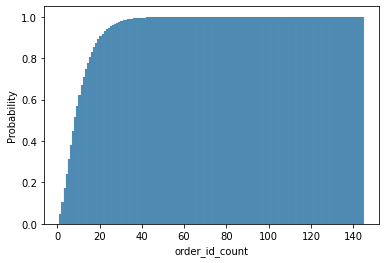

In [133]:
fig = sns.histplot(x=order_id_prior_count['order_id_count'], stat='percent', cumulative=True)

The prior orders also validate the previous point of looking at orders with 20 products maximum.

In [72]:
df_train_order_products_named = df_train_order_products.join(df_products, on='product_id', how='inner')

df_train_order_products_named.head()

order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
i64,i64,i64,i64,str,i64,i64
1,49302,1,1,"""Bulgarian Yogurt""",120,16
1,11109,2,1,"""Organic 4% Milk Fat Whole Milk Cottage Cheese""",108,16
1,10246,3,0,"""Organic Celery Hearts""",83,4
1,49683,4,0,"""Cucumber Kirby""",83,4
1,43633,5,1,"""Lightly Smoked Sardines in Olive Oil""",95,15


The orders table does not have the product name due to normalization so we denormalize it to bring the product name back into play

In [73]:
df_train_order_products_named.dtypes

[polars.datatypes.Int64,
 polars.datatypes.Int64,
 polars.datatypes.Int64,
 polars.datatypes.Int64,
 polars.datatypes.Utf8,
 polars.datatypes.Int64,
 polars.datatypes.Int64]

In [137]:
df_train_order_products_named.schema

{'order_id': polars.datatypes.Int64,
 'product_id': polars.datatypes.Int64,
 'add_to_cart_order': polars.datatypes.Int64,
 'reordered': polars.datatypes.Int64,
 'product_name': polars.datatypes.Utf8,
 'aisle_id': polars.datatypes.Int64,
 'department_id': polars.datatypes.Int64}

In [138]:
products_value_counts = df_train_order_products_named['product_name'].value_counts()

products_value_counts.head(10)

product_name,counts
str,u32
"""Banana""",18726
"""Bag of Organic Bananas""",15480
"""Organic Strawberries""",10894
"""Organic Baby Spinach""",9784
"""Large Lemon""",8135
"""Organic Avocado""",7409
"""Organic Hass Avocado""",7293
"""Strawberries""",6494
"""Limes""",6033


In [139]:
products_value_counts.shape

(39123, 2)

A quick glance into the data highlights the popularity of organic goods

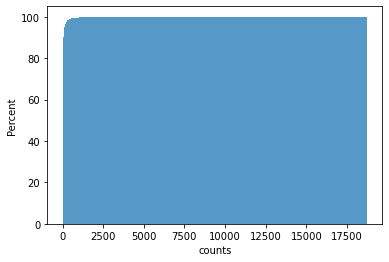

In [140]:
fig = sns.histplot(x=products_value_counts['counts'], stat='percent', cumulative=True)

It may be worth to examine to apply the pareto principle to the original 40,000 products to determine potentially which 20% of unique products result in 80% of the orders.

In [78]:
df_order_products_prior_named = df_order_products_prior.join(df_products, on='product_id', how='left')

df_order_products_prior_named.head()

order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
i64,i64,i64,i64,str,i64,i64
2,33120,1,1,"""Organic Egg Whites""",86,16
2,28985,2,1,"""Michigan Organic Kale""",83,4
2,9327,3,0,"""Garlic Powder""",104,13
2,45918,4,1,"""Coconut Butter""",19,13
2,30035,5,0,"""Natural Sweetener""",17,13


In [79]:
df_order_products_prior_named = df_order_products_prior_named.join(df_aisles, on='aisle_id', how='left')

df_order_products_prior_named.head()

order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle
i64,i64,i64,i64,str,i64,i64,str
2,33120,1,1,"""Organic Egg Whites""",86,16,"""eggs"""
2,28985,2,1,"""Michigan Organic Kale""",83,4,"""fresh vegetables"""
2,9327,3,0,"""Garlic Powder""",104,13,"""spices seasonings"""
2,45918,4,1,"""Coconut Butter""",19,13,"""oils vinegars"""
2,30035,5,0,"""Natural Sweetener""",17,13,"""baking ingredients"""


Let's take a look at the most popular products in the prior orders, regardless of whether they were or were not reordered

In [69]:
products_prior_value_counts = df_order_products_prior_named['product_name'].value_counts()

products_prior_value_counts.head(10)

product_name,counts
str,u32
"""Banana""",472565
"""Bag of Organic Bananas""",379450
"""Organic Strawberries""",264683
"""Organic Baby Spinach""",241921
"""Organic Hass Avocado""",213584
"""Organic Avocado""",176815
"""Large Lemon""",152657
"""Strawberries""",142951
"""Limes""",140627


Many of the current popular products are unsurprisingly popular products for prior orders

In [80]:
aisles_prior_value_counts = df_order_products_prior_named['aisle'].value_counts()

aisles_prior_value_counts.head(10)

aisle,counts
str,u32
"""fresh fruits""",3642188
"""fresh vegetables""",3418021
"""packaged vegetables fruits""",1765313
"""yogurt""",1452343
"""packaged cheese""",979763
"""milk""",891015
"""water seltzer sparkling water""",841533
"""chips pretzels""",722470
"""soy lactosefree""",638253


### Order Sequence

In [84]:
   df_order_products_prior.columns

['order_id', 'product_id', 'add_to_cart_order', 'reordered']

We can identify at which point a product was added to the cart and can dig into that.

In [105]:
order_products_prior_cart_sequence =  (
    df_order_products_prior
    .groupby('add_to_cart_order')
    .agg(
        [
            pl.col('reordered').mean().alias('Reordered Proportion')
        ]
    )
    .sort('add_to_cart_order')
)

order_products_prior_cart_sequence.head()

add_to_cart_order,Reordered Proportion
i64,f64
1,0.677533
2,0.676251
3,0.658037
4,0.636958
5,0.617383


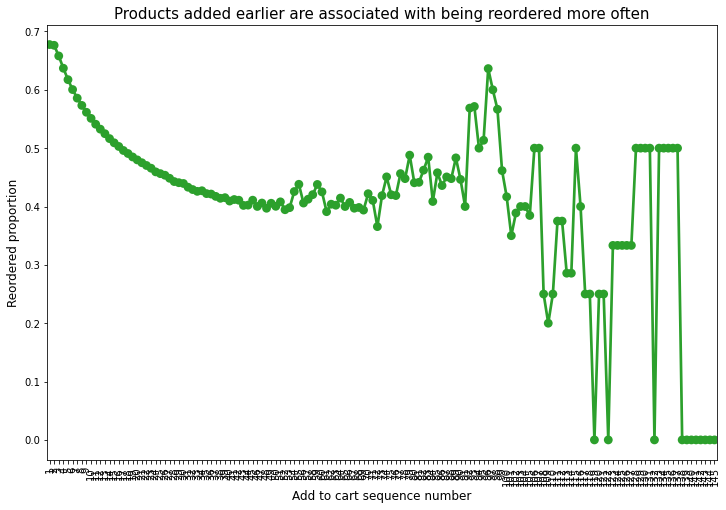

In [106]:
plt.figure(figsize=(12,8))

sns.pointplot(
    data = order_products_prior_cart_sequence.to_pandas()
    , x = 'add_to_cart_order'
    , y = 'Reordered Proportion'
    , alpha=0.8
    , color=color[2]
    )

plt.ylabel('Reordered proportion', fontsize=12)
plt.xlabel('Add to cart sequence number', fontsize=12)
plt.title("Products added earlier are associated with being reordered more often", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

What if we sliced by time to see if that affects a reorder?

In [110]:
df_train_order_products_combined.columns

['order_id',
 'product_id',
 'add_to_cart_order',
 'reordered',
 'product_name',
 'aisle_id',
 'department_id',
 'aisle',
 'department',
 'user_id',
 'eval_set',
 'order_number',
 'order_dow',
 'order_hour_of_day',
 'days_since_prior_order']

In [118]:
order_products_day_sequence =  (
    df_train_order_products_combined
    .groupby('order_dow')
    .agg(
        [
            pl.col('reordered').mean().alias('Reordered Proportion')
        ]
    )
    .sort('order_dow')
)

order_products_day_sequence.head()

order_dow,Reordered Proportion
i64,f64
0,0.586483
1,0.603672
2,0.589720
3,0.586289
4,0.591123


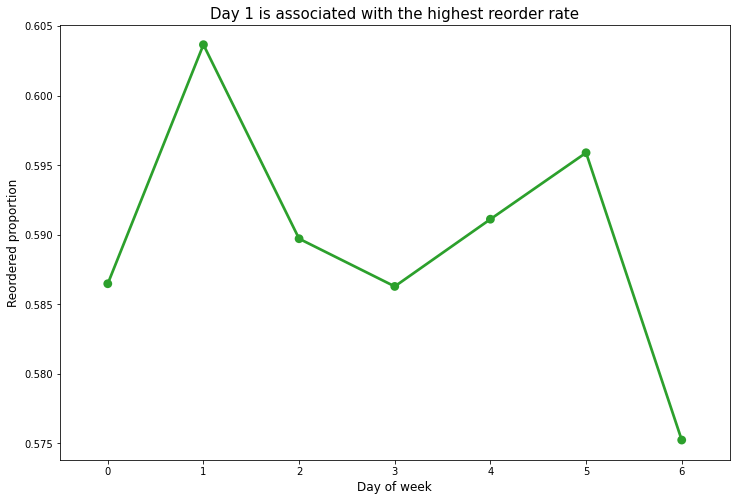

In [119]:
plt.figure(figsize=(12,8))

sns.pointplot(
    data = order_products_day_sequence.to_pandas()
    , x = 'order_dow'
    , y = 'Reordered Proportion'
    , alpha=0.8
    , color=color[2]
    )

plt.ylabel('Reordered proportion', fontsize=12)
plt.xlabel('Day of week', fontsize=12)
plt.title("Day 1 is associated with the highest reorder rate", fontsize=15)

plt.show()

In [120]:
order_products_hour_sequence =  (
    df_train_order_products_combined
    .groupby('order_hour_of_day')
    .agg(
        [
            pl.col('reordered').mean().alias('Reordered Proportion')
        ]
    )
    .sort('order_hour_of_day')
)

order_products_hour_sequence.head()

order_hour_of_day,Reordered Proportion
i64,f64
0,0.565726
1,0.558149
2,0.555574
3,0.560501
4,0.572370


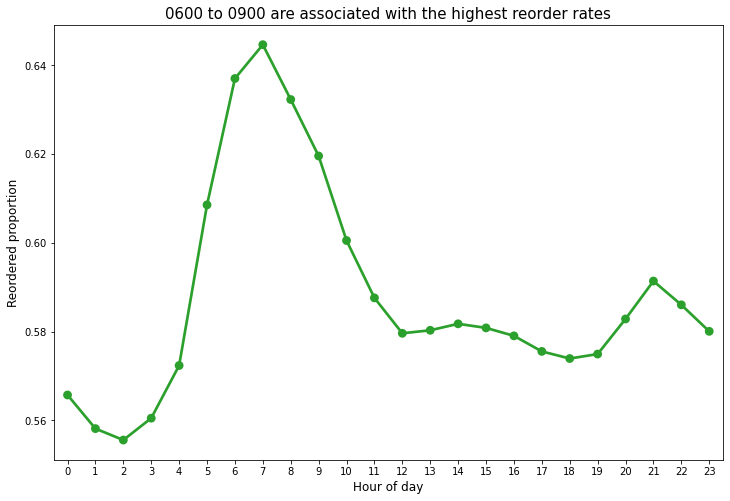

In [123]:
plt.figure(figsize=(12,8))

sns.pointplot(
    data = order_products_hour_sequence.to_pandas()
    , x = 'order_hour_of_day'
    , y = 'Reordered Proportion'
    , alpha=0.8
    , color=color[2]
    )

plt.ylabel('Reordered proportion', fontsize=12)
plt.xlabel('Hour of day', fontsize=12)
plt.title("0600 to 0900 are associated with the highest reorder rates", fontsize=15)

plt.show()

In [127]:
df_reorders = (
    df_train_order_products_combined
    .groupby(
        [
            'order_dow'
            , 'order_hour_of_day'
        ]
        )
    .agg(
        [
            pl.col('reordered').mean().alias('Reordered Proportion')
        ]
    )
    .sort(
        [
            'order_dow'
            , 'order_hour_of_day'
        ]
        )
)

df_reorders.head()

order_dow,order_hour_of_day,Reordered Proportion
i64,i64,f64
0,0,0.576550
0,1,0.553474
0,2,0.554843
0,3,0.568533
0,4,0.548804


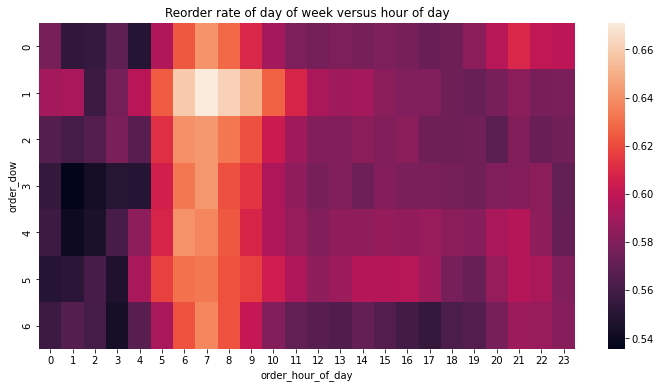

In [129]:
df_reorders_pivot = df_reorders.to_pandas().pivot(
    index='order_dow'
    , columns='order_hour_of_day'
    , values='Reordered Proportion'
    )

plt.figure(figsize=(12,6))
sns.heatmap(df_reorders_pivot)
plt.title('Reorder rate of day of week versus hour of day')

plt.show()